Dataset Link: https://huggingface.co/datasets/fancyzhx/dbpedia_14

X_Train shape: (448000, 256)
Label Shape: (448000, 14)
Vocab size: 30000


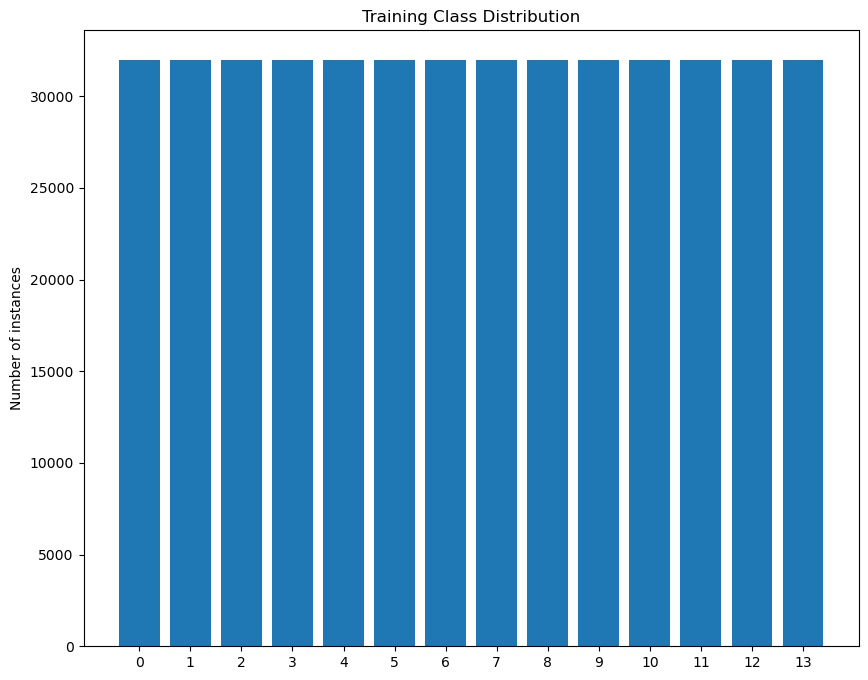

In [9]:
from datasets import load_dataset
from keras.src.layers import MultiHeadAttention
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical

import os
import re
import spacy
import numpy as np
import matplotlib.pyplot as plt
os.environ['KMP_DUPLICATE_LIB_OK']='True'

"""
https://www.datacamp.com/cheat-sheet/regular-expresso
"""
def clean_text(text):
    text = re.sub(r"<.*?>", " ", text)               # remove HTML tags
    text = re.sub(r"&\w+;", " ", text)               # remove HTML entities
    text = re.sub(r"[^a-z0-9\s]", " ", text)         # remove punctuation
    text = re.sub(r"\s+", " ", text).strip()         # normalize spaces
    return text
    
    
dbpedia = load_dataset("dbpedia_14")

text = dbpedia["train"]["content"]
labels = dbpedia["train"]["label"]


NUM_CLASSES = 14
MAX_SEQ_LEN = 256 
MAX_VOCAB_SIZE = 30000   



X_train, X_test, y_train, y_test = train_test_split(text, labels, test_size=0.2, random_state=42, stratify=labels)

X_train = [clean_text(t) for t in X_train]
X_test = [clean_text(t) for t in X_test]

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE)
tokenizer.fit_on_texts(X_train)
X_train_cov_seq = tokenizer.texts_to_sequences(X_train)
X_test_cov_seq = tokenizer.texts_to_sequences(X_test)

# Pad Sequences
X_train = sequence.pad_sequences(X_train_cov_seq, maxlen=MAX_SEQ_LEN)
X_test = sequence.pad_sequences(X_test_cov_seq, maxlen=MAX_SEQ_LEN)

#One Hot 
y_train = to_categorical(y_train, NUM_CLASSES)
y_test = to_categorical(y_test, NUM_CLASSES)

print(f"X_Train shape: {X_train.shape}")
print(f"Label Shape: {y_train.shape}")
print(f"Vocab size: {MAX_VOCAB_SIZE}")

class_count = np.sum(y_train, axis=0)
plt.figure(figsize=(10, 8))
plt.bar(range(NUM_CLASSES), class_count)
plt.xticks(range(NUM_CLASSES))
plt.ylabel("Number of instances")
plt.title("Training Class Distribution")
plt.show()

## Dataset Preparation, Evaluation Metrics, and Split Method


### Methods of Tokenization/Sequence Length

For tokenization, I used Keras Tokenization because the DBPedia dataset is very large at 560,000+, so to keep the model size reasonable and memory limited I capped the vocabulary at 30,000 and also capped the sequence length to 256 since we don't need the entire documents tokens. The entries in the dataset varies in length more often than not, so the sequence length seemed like a good compromise and lead to consistent input shape into the model.

I chose macro-averaged F1 for model evaluation. This decision was motivated by a paper on DBpedia ontology classification (Zhang et al., 2023), which uses the same method of metrics. Thier justification was that the ontology mapping and type prediction are multi class problems where each class is equally important even for distributively balanced classes. These assumption lines up with my use case as the class distribution in my dataset are more or less balanced, but each label represents a semantic category. Mistakes in prediction of one class wouldn't have equal impact another class, so just averaging across makes sense in this case rather letting a heavy class take over accuracy metrics. This relates to the similar business case the researchers in the paper were studying. If I were to use the semantic classifier models evaluated in this lab in a knowledge graph system, id want equally performance across all classes, macro F1 would reinforce my goal of fairness in models.

For the test/training I chose a stratified 20/80 split. Stratification keeps the class distribution the same in both sets equal to avoid imbalances. I didn't want to use n-fold cross validation because this would greatly increase the training time and not very practical for me since im limited on compute power. Also, a single split might be more realistic as for this type of classifier you usually train on one large chunk of text then evaluate on held out document sets the model hasn't seen. This leaves a good amount of data the model can train on to learn enough stable patterns and get as close to generalization as possible.

Zhang, Z., Wang, Z., & Iwaihara, M. (2023). Mapping Wikipedia Categories and Lists to DBPedia Ontology Based on Structural and Semantic Features. DEIM Forum. https://proceedings-of-deim.github.io/DEIM2023/1b-3-4.pdf

## Modeling

In [27]:

# Baseline CNN Model

from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D
from tensorflow.keras.layers import Dropout, GlobalMaxPool1D, Dense
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_SIZE = 64
SEQ_LEN = MAX_SEQ_LEN

inputs = Input(shape=SEQ_LEN, dtype='int32')

# Using my original embeddings
embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_SIZE,
    input_length=SEQ_LEN)(inputs)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(embedding)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.2)(x)

x = Conv1D(64, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = GlobalMaxPool1D()(x)

x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)

preds = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)
model = Model(inputs, preds)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)

optimizer = Adam(epsilon=0.0001, learning_rate=lr_schedule)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

model.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 256)]             0         
                                                                 
 embedding_9 (Embedding)     (None, 256, 64)           1920000   
                                                                 
 conv1d_27 (Conv1D)          (None, 252, 64)           20544     
                                                                 
 max_pooling1d_18 (MaxPooli  (None, 50, 64)            0         
 ng1D)                                                           
                                                                 
 dropout_26 (Dropout)        (None, 50, 64)            0         
                                                                 
 conv1d_28 (Conv1D)          (None, 46, 64)            20544     
                                                           

In [28]:
histories = []
baseline_hist = model.fit(
    X_train, y_train, 
    epochs=5, 
    validation_data=(X_test, y_test),
    batch_size=128)
histories.append(baseline_hist)

Epoch 1/5


2025-12-10 14:24:53.870789: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.4229 - acc: 0.8620

2025-12-10 14:25:54.862920: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 67s 19ms/step - loss: 0.4229 - acc: 0.8620 - val_loss: 0.1566 - val_acc: 0.9533
Epoch 2/5
3500/3500 [==============================] - 59s 17ms/step - loss: 0.1560 - acc: 0.9545 - val_loss: 0.1470 - val_acc: 0.9568
Epoch 3/5
3500/3500 [==============================] - 67s 19ms/step - loss: 0.1378 - acc: 0.9602 - val_loss: 0.1550 - val_acc: 0.9557
Epoch 4/5
3500/3500 [==============================] - 68s 19ms/step - loss: 0.1854 - acc: 0.9558 - val_loss: 0.3053 - val_acc: 0.9475
Epoch 5/5
3500/3500 [==============================] - 60s 17ms/step - loss: 1.4171 - acc: 0.9395 - val_loss: 3.2699 - val_acc: 0.9384


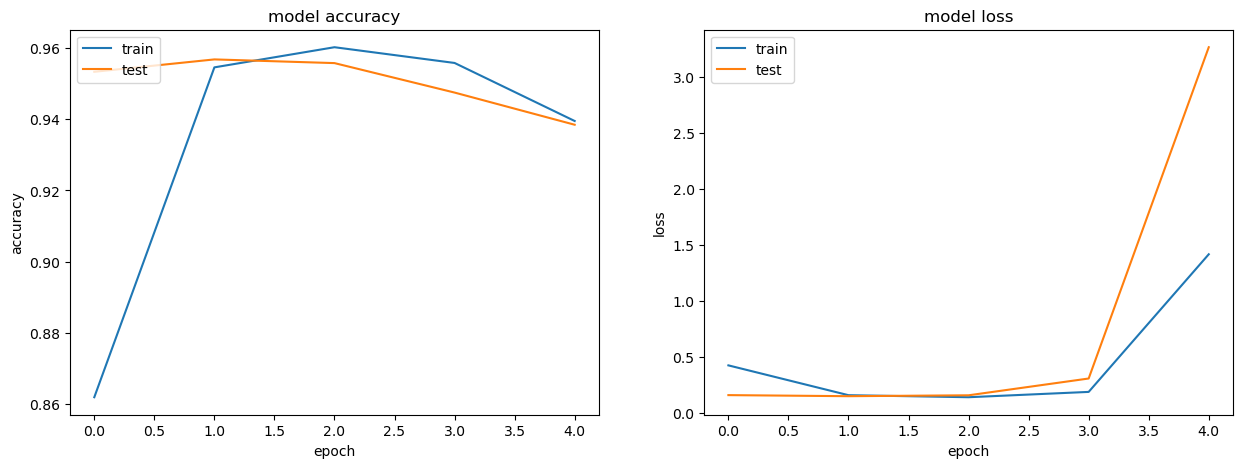

In [29]:
from sklearn import metrics as mt
from matplotlib import pyplot as plt
%matplotlib inline

# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [40]:
from tensorflow.keras.layers import GlobalAveragePooling1D, Subtract, Concatenate, LayerNormalization


VOCAB_SIZE = MAX_VOCAB_SIZE
EMBEDDING_SIZE = 64
SEQ_LEN = MAX_SEQ_LEN

inputs = Input(shape=SEQ_LEN, dtype='int32')

# Using my original embeddings
embedding = Embedding(
    input_dim=VOCAB_SIZE,
    output_dim=EMBEDDING_SIZE,
    input_length=SEQ_LEN)(inputs)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(embedding)
x = LayerNormalization()(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.1)(x)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = LayerNormalization()(x)
x = MaxPooling1D(5)(x)
x = Dropout(0.1)(x)

x = Conv1D(128, 5, activation='relu', kernel_initializer='he_uniform')(x)
x = LayerNormalization()(x)
x = Dropout(0.1)(x)


# Adding mean and average variance pooling
x = LayerNormalization()(x)
x_mean = GlobalAveragePooling1D()(x)
# Taking the average
x_centered = Subtract()([x, x_mean])
x_var = GlobalAveragePooling1D()(x_centered ** 2)

x = Concatenate()([x_mean, x_var])

x = Dense(128, activation='relu', kernel_initializer='he_uniform')(x)
x = Dropout(0.2)(x)


preds = Dense(NUM_CLASSES, activation='softmax', kernel_initializer='glorot_uniform')(x)
cnn_model_b = Model(inputs, preds)

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.95,
    staircase=True
)

optimizer = Adam(epsilon=1e-5, learning_rate=lr_schedule)

cnn_model_b.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['acc'])

cnn_model_b.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_15 (InputLayer)       [(None, 256)]                0         []                            
                                                                                                  
 embedding_14 (Embedding)    (None, 256, 64)              1920000   ['input_15[0][0]']            
                                                                                                  
 conv1d_42 (Conv1D)          (None, 252, 128)             41088     ['embedding_14[0][0]']        
                                                                                                  
 layer_normalization_1 (Lay  (None, 252, 128)             256       ['conv1d_42[0][0]']           
 erNormalization)                                                                          

In [41]:
histories_b = []

history_b = cnn_model_b.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_b.append(history_b)

Epoch 1/5


2025-12-10 17:27:25.274349: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3498/3500 [============================>.] - ETA: 0s - loss: 0.8963 - acc: 0.7059

2025-12-10 17:28:52.437555: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 95s 27ms/step - loss: 0.8959 - acc: 0.7061 - val_loss: 0.2314 - val_acc: 0.9325
Epoch 2/5
3500/3500 [==============================] - 100s 28ms/step - loss: 0.2142 - acc: 0.9362 - val_loss: 0.1766 - val_acc: 0.9487
Epoch 3/5
3500/3500 [==============================] - 118s 34ms/step - loss: 0.1515 - acc: 0.9547 - val_loss: 0.1620 - val_acc: 0.9535
Epoch 4/5
3500/3500 [==============================] - 117s 33ms/step - loss: 0.1207 - acc: 0.9638 - val_loss: 0.1641 - val_acc: 0.9550
Epoch 5/5
3500/3500 [==============================] - 116s 33ms/step - loss: 0.1009 - acc: 0.9696 - val_loss: 0.1611 - val_acc: 0.9557


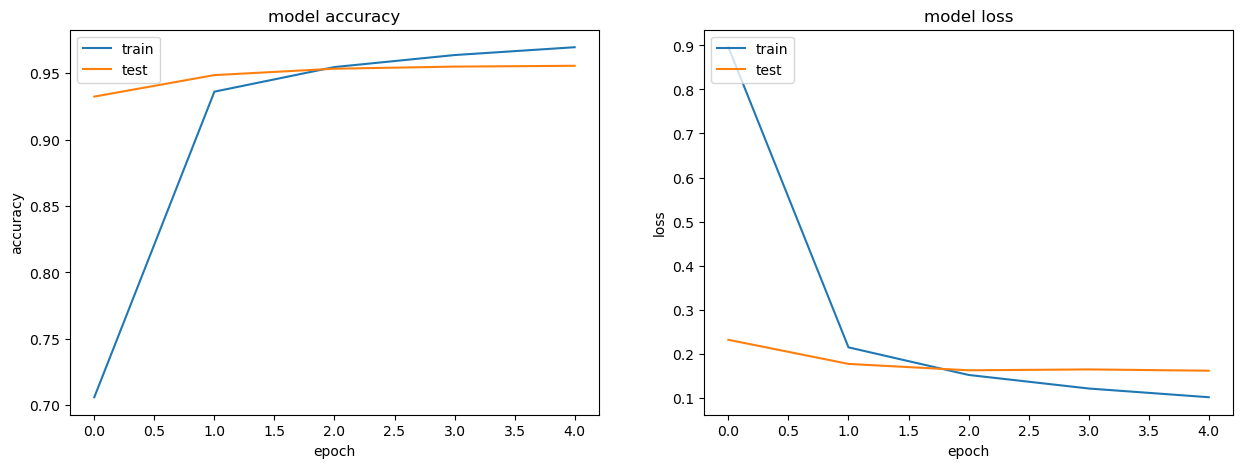

In [43]:


# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_b])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Transformer Models

In [54]:
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Layer
import tensorflow as tf

# Transformer Block and Position Embeddings
# Embeddings are based my own and not pre-trained
class TransformerBlock(Layer):
    def __init__(self, embed_dims, num_head, ff_dim, rate=0.1):
        super().__init__()
        self.att = MultiHeadAttention(num_heads=num_head, key_dim=embed_dims)
        self.ffn = Sequential([Dense(ff_dim, activation='relu'),
                               Dense(embed_dims)])
        
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
        
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)
    
class TokenAndPositionEmbedding(Layer):
    def __init__(self, vocab_size, embed_dim, max_len):
        super().__init__()
        self.token_embedding = Embedding(vocab_size, embed_dim)
        self.position_embedding = Embedding(max_len, embed_dim)
        
    def call(self, x):
        max_len = tf.shape(x)[-1]
        position = tf.range(0, max_len, delta=1)
        position = self.position_embedding(position)
        x = self.token_embedding(x)
        return x + position

In [55]:
# Transformer Model A

embed_dims = 32
num_head = 1
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = TokenAndPositionEmbedding(VOCAB_SIZE, embed_dims, max_len)(inputs)

# Block 1
x = TransformerBlock(embed_dims, num_head, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(64, 'relu')(x)
x = Dropout(0.1)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_A = Model(inputs, outputs)

transformer_model_A.compile(loss='categorical_crossentropy', 
                            optimizer='rmsprop', 
                            metrics=['acc'])

transformer_model_A.summary()

Model: "model_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_20 (InputLayer)       [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 32)           968192    
 ng_4 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_4 (Trans  (None, 256, 32)           8544      
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 32)                0         
 3 (GlobalAveragePooling1D)                                      
                                                                 
 dropout_61 (Dropout)        (None, 32)                0  

In [58]:
histories_trans_a = []

hist_trans_a = transformer_model_A.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_a.append(hist_trans_a)

Epoch 1/5
3500/3500 [==============================] - 378s 108ms/step - loss: 0.0611 - acc: 0.9838 - val_loss: 0.0639 - val_acc: 0.9825
Epoch 2/5
3500/3500 [==============================] - 385s 110ms/step - loss: 0.0596 - acc: 0.9842 - val_loss: 0.0656 - val_acc: 0.9822
Epoch 3/5
3500/3500 [==============================] - 380s 109ms/step - loss: 0.0588 - acc: 0.9846 - val_loss: 0.0639 - val_acc: 0.9825
Epoch 4/5
3500/3500 [==============================] - 381s 109ms/step - loss: 0.0585 - acc: 0.9846 - val_loss: 0.0650 - val_acc: 0.9830
Epoch 5/5
3500/3500 [==============================] - 381s 109ms/step - loss: 0.0576 - acc: 0.9848 - val_loss: 0.0680 - val_acc: 0.9820


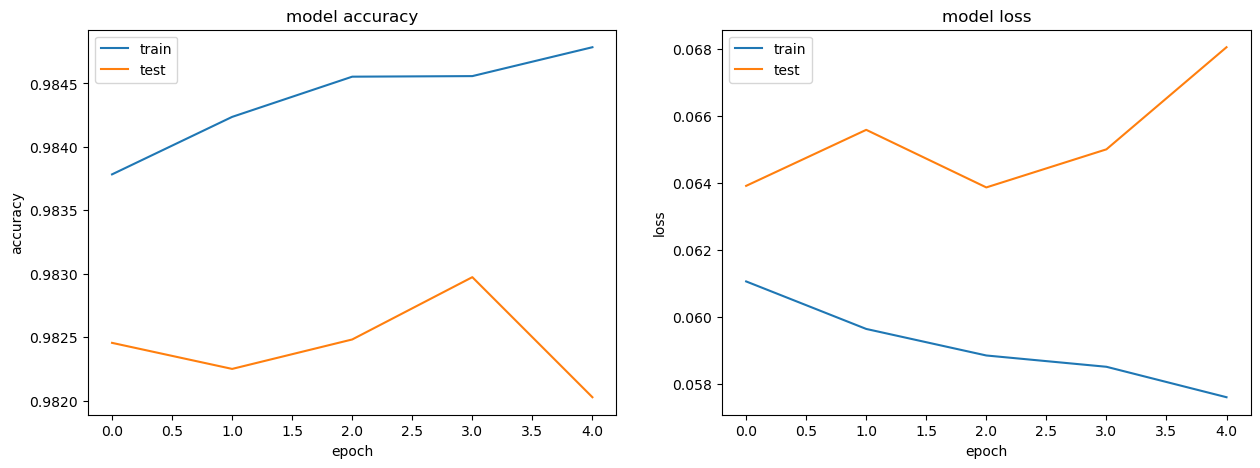

In [59]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_a])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [62]:
embed_dims = 64
num_heads = 2
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = TokenAndPositionEmbedding(VOCAB_SIZE, embed_dims, max_len)(inputs)

# Block 1
x = TransformerBlock(embed_dims, num_heads, ff_dim)(x)

# Block 2
x = TransformerBlock(embed_dims, num_heads, ff_dim)(x)

x = GlobalAveragePooling1D()(x)
x = Dropout(0.25)(x)
x = Dense(128, 'relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_B = Model(inputs, outputs)

transformer_model_B.compile(loss='categorical_crossentropy', 
                            optimizer='rmsprop', 
                            metrics=['acc'])

transformer_model_B.summary()

Model: "model_18"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_22 (InputLayer)       [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 64)           1936384   
 ng_6 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_7 (Trans  (None, 256, 64)           41792     
 formerBlock)                                                    
                                                                 
 transformer_block_8 (Trans  (None, 256, 64)           41792     
 formerBlock)                                                    
                                                                 
 global_average_pooling1d_1  (None, 64)                0  

In [63]:
histories_trans_b = []

hist_trans_b = transformer_model_B.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_b.append(hist_trans_b)

Epoch 1/5


2025-12-11 16:38:16.443433: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.1763 - acc: 0.9505

2025-12-11 17:04:05.633601: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 1700s 485ms/step - loss: 0.1763 - acc: 0.9505 - val_loss: 0.0806 - val_acc: 0.9778
Epoch 2/5
3500/3500 [==============================] - 1448s 414ms/step - loss: 0.0719 - acc: 0.9814 - val_loss: 0.0902 - val_acc: 0.9761
Epoch 3/5
3500/3500 [==============================] - 1441s 412ms/step - loss: 0.0627 - acc: 0.9840 - val_loss: 0.0609 - val_acc: 0.9840
Epoch 4/5
3500/3500 [==============================] - 1430s 408ms/step - loss: 0.0581 - acc: 0.9848 - val_loss: 0.0599 - val_acc: 0.9845
Epoch 5/5
3500/3500 [==============================] - 1440s 411ms/step - loss: 0.0540 - acc: 0.9859 - val_loss: 0.0557 - val_acc: 0.9847


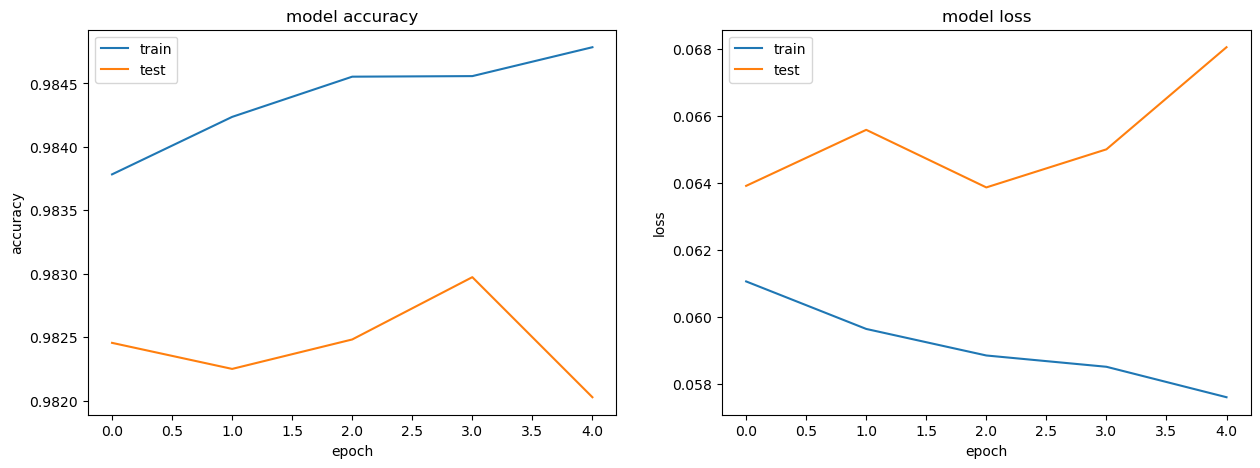

In [64]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_b])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Transformer B Parameters with Learning Rate Scheduler

In [65]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import RMSprop

embed_dims = 64
num_heads = 2
ff_dim = 64
max_len = MAX_SEQ_LEN # 256 Seq Length

inputs = Input((max_len,), dtype='int32')

x = TokenAndPositionEmbedding(VOCAB_SIZE, embed_dims, max_len)(inputs)

# Block 1
first_layer = TransformerBlock(embed_dims, num_heads, ff_dim)(x)

# Block 2
second_layer = TransformerBlock(embed_dims, num_heads, ff_dim)(first_layer)

x = GlobalAveragePooling1D()(second_layer)
x = Dropout(0.25)(x)
x = Dense(128, 'relu')(x)
x = Dropout(0.25)(x)

outputs = Dense(NUM_CLASSES, activation='softmax')(x)

transformer_model_C = Model(inputs, outputs)

lr_scheduler = ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9,
    staircase=True
)

optimizer = RMSprop(learning_rate=lr_scheduler)

transformer_model_C.compile(loss='categorical_crossentropy', 
                            optimizer=optimizer, 
                            metrics=['acc'])

transformer_model_C.summary()

Model: "model_19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_23 (InputLayer)       [(None, 256)]             0         
                                                                 
 token_and_position_embeddi  (None, 256, 64)           1936384   
 ng_7 (TokenAndPositionEmbe                                      
 dding)                                                          
                                                                 
 transformer_block_9 (Trans  (None, 256, 64)           41792     
 formerBlock)                                                    
                                                                 
 transformer_block_10 (Tran  (None, 256, 64)           41792     
 sformerBlock)                                                   
                                                                 
 global_average_pooling1d_1  (None, 64)                0  

In [66]:
histories_trans_c = []

hist_trans_c = transformer_model_C.fit(
    X_train, y_train,
    epochs=5,
    batch_size=128,
    validation_data=(X_test, y_test)
)

histories_trans_c.append(hist_trans_c)

Epoch 1/5


2025-12-11 20:45:23.098381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - ETA: 0s - loss: 0.1739 - acc: 0.9506

2025-12-11 21:08:09.239597: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


3500/3500 [==============================] - 1521s 433ms/step - loss: 0.1739 - acc: 0.9506 - val_loss: 0.0666 - val_acc: 0.9832
Epoch 2/5
3500/3500 [==============================] - 1428s 408ms/step - loss: 0.0701 - acc: 0.9820 - val_loss: 0.0682 - val_acc: 0.9814
Epoch 3/5
3500/3500 [==============================] - 1484s 424ms/step - loss: 0.0614 - acc: 0.9842 - val_loss: 0.0532 - val_acc: 0.9854
Epoch 4/5
3500/3500 [==============================] - 1429s 408ms/step - loss: 0.0562 - acc: 0.9856 - val_loss: 0.0585 - val_acc: 0.9836
Epoch 5/5
3500/3500 [==============================] - 1476s 422ms/step - loss: 0.0534 - acc: 0.9863 - val_loss: 0.0622 - val_acc: 0.9846


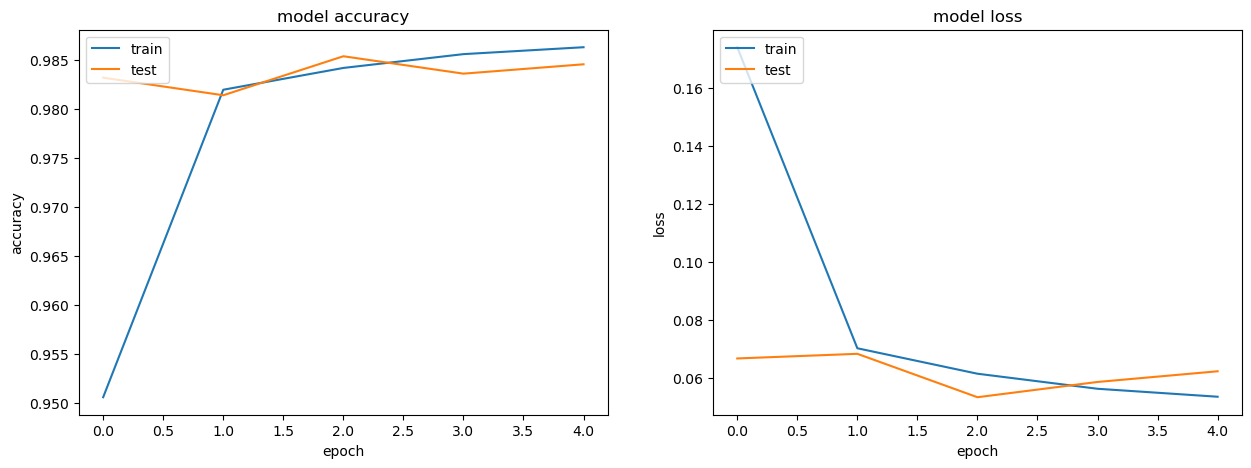

In [67]:
# combine all the history from training together
combined = dict()
for key in ['acc','val_acc','loss','val_loss']:
    combined[key] = np.hstack([x.history[key] for x in histories_trans_c])
    
# summarize history for accuracy
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.plot(combined['acc'])
plt.plot(combined['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# summarize history for loss
plt.subplot(122)
plt.plot(combined['loss'])
plt.plot(combined['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()